In [ ]:
!pip install torch torchvision transformers
#!pip install wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import torch.nn as nn
import os
import json
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertModel, BertTokenizer
#import wandb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
#import wandb
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
#Setup CNN for reverse pass
class smallBoy(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=128, device="cpu"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.cnn = nn.Sequential(
            nn.Conv2d(c_in, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, t):
        return self.cnn(x)

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, img_dir, caption_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(caption_file, 'r') as f:
            self.captions = json.load(f)
        self.filenames = list(self.captions.keys())

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        caption = self.captions[img_name]
        return image, caption

In [ ]:
def apply_canny_edge_detector(image, low_threshold=100, high_threshold=200):
    image = image * 255
    batch_np = image.numpy().astype(np.uint8)
    edge_maps = []

    for image_np in batch_np:
        if image_np.shape[0] == 3:
            image_np = cv2.cvtColor(image_np.transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)
        blurred_image = cv2.GaussianBlur(image_np, (3, 3), 0)
        edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
        edge_maps.append(edges)

    edge_tensor = torch.from_numpy(np.stack(edge_maps, axis=0)).unsqueeze(1).float() / 255
    return edge_tensor

def apply_canny_edge_detector_rgb(image, low_threshold=100, high_threshold=200):
  image = image * 255
  batch_np = image.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
  edge_masked_images = []

  for image_np in batch_np:
      if image_np.shape[-1] == 3:
          gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
      else:
          gray_image = image_np.squeeze()

      blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
      edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
      edge_mask = edges / 255.0
      edge_mask = np.expand_dims(edge_mask, axis=-1)
      edge_masked_image = image_np * edge_mask
      edge_masked_image[edge_masked_image == 0] = 127.5
      edge_masked_images.append(edge_masked_image)

  edge_masked_tensor = torch.from_numpy(np.stack(edge_masked_images, axis=0)).permute(0, 3, 1, 2).float() / 255
  return edge_masked_tensor

In [ ]:
class DiffusionModel(nn.Module):
    def __init__(self, beta_start, beta_end, steps, device = "cuda"):
        super(DiffusionModel, self).__init__()
        self.device = device

        self.delta_network = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.recovery_network = smallBoy(c_in=3, c_out=3, time_dim=256, device=self.device)

        #Noise schedule
        self.beta_t = torch.linspace(beta_start, beta_end, steps=steps)
        self.alpha_t = torch.cumprod(1 - self.beta_t, dim=0)

        #Text embeddings
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def compute_delta(self, text_features, t):
        delta_scale = self.delta_network(text_features).squeeze()
        return delta_scale

    def forward_pass(self, m, m_rgb, captions, t):
        inputs = self.bert_tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
        outputs = self.bert_model(**inputs)
        text_embed = outputs.last_hidden_state[:, 0, :]

        alpha_t = self.alpha_t[t]
        one_minus_alpha_t = 1 - alpha_t
        unmasked_regions = torch.ones_like(m) - m
        delta = self.compute_delta(text_embed, t).float()

        delta = delta.float()
        weighted_noise = torch.randn_like(m) * delta[0]

        m_rgb = m_rgb.float()
        x_t = m + (unmasked_regions)*(torch.sqrt(alpha_t) * m_rgb * unmasked_regions + torch.sqrt(one_minus_alpha_t) * weighted_noise)
        return torch.clamp(x_t, 0, 1)

    '''
    def reverse_pass(self, x_t, m, t):
        # Compute recovery parameters
        t = torch.tensor(t, dtype=torch.long)
        recovery_params = self.recovery_network(x_t, t)
        unmasked_regions = torch.ones_like(m) - m

        # Get noise
        noise = torch.randn_like(x_t)
        beta = self.beta_t[t]

        # Reverse pass equation
        x_0 = 1 / torch.sqrt(self.alpha_t[t]) * (x_t - unmasked_regions * (1-self.alpha_t[t])/(torch.sqrt(1 - self.alpha_t[t])) * recovery_params) + torch.sqrt(beta) * noise * unmasked_regions
        return torch.clamp(x_0, 0, 1)
    '''
    def reverse_pass(self, x_t, m, t):
        unmasked_regions = 1 - m
        for i in reversed(range(t)):
            t_i = torch.tensor(i, dtype=torch.long).to(x_t.device)
            recovery_params = self.recovery_network(x_t, t_i)

            noise = torch.randn_like(x_t, device=x_t.device)
            beta = self.beta_t[i]

            #Calculate reusable values
            alpha_t_sqrt_inv = 1 / torch.sqrt(self.alpha_t[i])
            alpha_t_sqrt_diff_inv = (1 - self.alpha_t[i]) / torch.sqrt(1 - self.alpha_t[i])
            beta_sqrt = torch.sqrt(beta)

            #Reverse pass equation
            x_tminus1 = (
                alpha_t_sqrt_inv * (x_t - unmasked_regions * alpha_t_sqrt_diff_inv * recovery_params) +
                beta_sqrt * noise * unmasked_regions
            )

            x_t = torch.clamp(x_tminus1, 0, 1)

            del t_i, recovery_params, noise, beta, alpha_t_sqrt_inv, alpha_t_sqrt_diff_inv, beta_sqrt, x_tminus1
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        return x_t

    def diffusion_loss(self, actual_noise, predicted_noise):
      loss = F.mse_loss(predicted_noise, actual_noise)
      return loss



In [ ]:
def imshow(inp, title=None):
    inp = inp.detach()
    if inp.is_cuda:
        inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_images(images, title=""):
    out = make_grid(images)
    imshow(out, title=title)


In [ ]:
def load_latest_checkpoint(checkpoint_dir):
  checkpoint_files = sorted(os.listdir(checkpoint_dir), key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)))
  latest_checkpoint = checkpoint_files[-1] if checkpoint_files else None
  if latest_checkpoint:
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    model = DiffusionModel(beta_start=0.0001, beta_end=0.02, steps=1000, device="cuda")
    model.load_state_dict(torch.load(latest_checkpoint_path))

    print(f"Loaded checkpoint '{latest_checkpoint}'")
    return model
  else:
      print("No checkpoints found.")
      model = DiffusionModel(beta_start=0.0001, beta_end=0.02, steps=1000, device="cuda")
      return model

In [ ]:
class Params:
    def __init__(self):
        self.epochs = 10
        self.batch_size = 16
        self.learning_rate = 1e-4

config = Params()

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((512, 512)),
    transforms.ToTensor(),
])

T = 1000 #Total number of diffusion steps

#wandb.init(project='my_diffusion_project', entity='michaelpeng72', config=config, id='diffusion_training', resume = 'allow')

dataset_path = '/content/drive/My Drive/Final Project/datasets'
img_dir = os.path.join(dataset_path, 'images')
caption_file = os.path.join(dataset_path, 'map.json')
full_dataset = ImageCaptionDataset(img_dir, caption_file, transform=transform)

train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

model = load_latest_checkpoint('/content/drive/My Drive/Final Project/checkpoints/second_model')
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

No checkpoints found.


Starting Epoch:  0


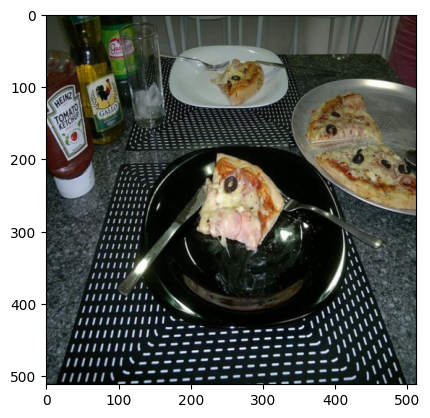

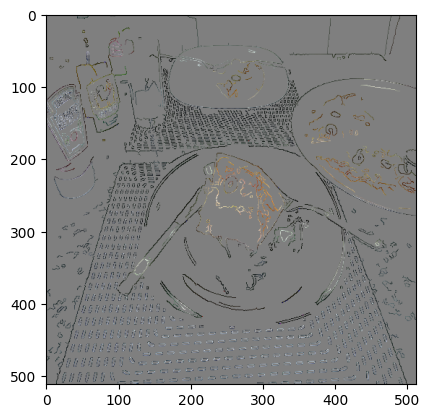

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34


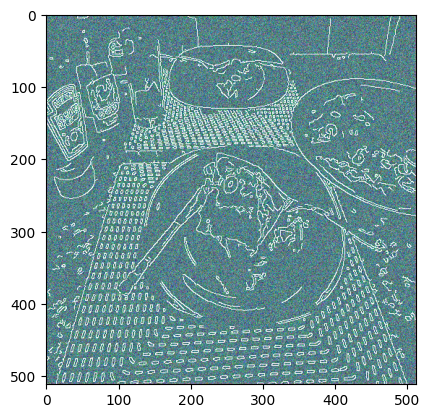

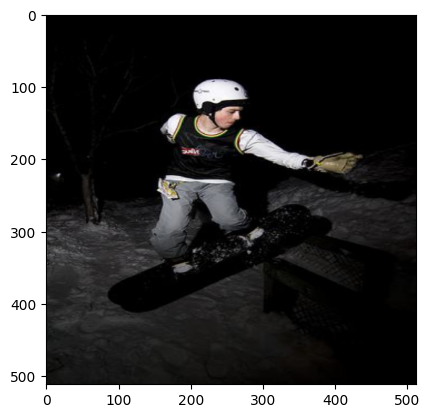

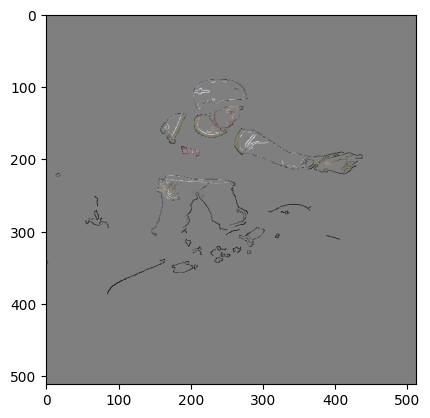

112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112


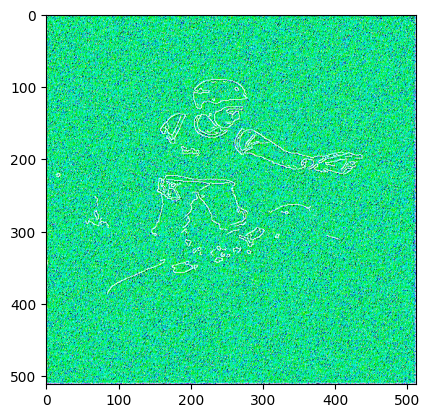

KeyboardInterrupt: 

In [ ]:
for epoch in range(0, config.epochs):
    print("Starting Epoch: ", epoch)
    model.train()
    train_loss = 0
    total_bits = 0
    total_pixels = 0

    for images, captions in train_loader:
        m_rgb = apply_canny_edge_detector_rgb(images)
        m = apply_canny_edge_detector(images)
        t = torch.randint(0, T, (1,)).item()

        show_images(images[0])
        show_images(m_rgb[0])

        noised_images = model.forward_pass(m, m_rgb, captions, t)
        recovered_images = model.reverse_pass(noised_images, m, t)

        show_images(recovered_images[0])

        loss = model.diffusion_loss((noised_images - images), (noised_images - recovered_images))
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #wandb.log({"train_loss_by_batch": loss.item()})
        total_bits += m.sum().item()
        total_pixels += images.numel() / images.shape[1]

    train_loss /= len(train_loader)
    bpp = total_bits / total_pixels
    #wandb.log({"train_loss_by_epoch": train_loss})

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for images, captions in valid_loader:
            m_rgb = apply_canny_edge_detector_rgb(images)
            m = apply_canny_edge_detector(images)
            t = torch.randint(0, T, (1,)).item()

            noised_images = model.forward_pass(m, m_rgb, captions, t)
            recovered_images = model.reverse_pass(noised_images, m, t)

            loss = model.diffusion_loss((noised_images - images), (noised_images - recovered_images))
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    #wandb.log({"valid_loss": valid_loss})

    compression_rate = np.mean(compression_rate)
    #wandb.log({"compression_rate": compression_rate})

    print("Epoch: ", epoch, "Train Loss: ", train_loss, "Valid Loss: ", valid_loss, "Compression Rate: ", bpp)

    checkpoint_path = f'/content/drive/My Drive/Final Project/checkpoints/epoch_{epoch}_checkpoint.pth'
    torch.save(model.state_dict(), checkpoint_path)

#wandb.finish()

Benchmark Inference Times

In [ ]:
model = load_latest_checkpoint('/content/drive/My Drive/2023-24/6.8300/Final Project/checkpoints/first_model')
config.batch_size = 1
def measure_inference_speed(model, loader, batch_sizes, T):
    times = {bs: [] for bs in batch_sizes}

    for bs in batch_sizes:
        print(bs)
        model.eval()
        batch_data = []
        images_processed = 0
        for images, captions in loader:
            if len(batch_data) < bs:
                batch_data.append((images, captions))
            if len(batch_data) >= bs:
                images = torch.cat([data[0] for data in batch_data], dim=0)
                captions = [caption for data in batch_data for caption in data[1]]
                batch_data = []

                m_rgb = apply_canny_edge_detector_rgb(images)
                m = apply_canny_edge_detector(images)
                t = torch.randint(0, T, (1,)).item()

                start_time = time.time()

                noised_images = model.forward_pass(m, m_rgb, captions, t)
                recovered_images = model.reverse_pass(noised_images, m, t)

                end_time = time.time()
                times[bs].append(end_time - start_time)


                break

    for bs in batch_sizes:
        if times[bs]: #avoid division by zero
            print(f'Average inference time for batch size {bs}: {sum(times[bs]) / len(times[bs]):.4f} seconds')
        else:
            print(f'No data for batch size {bs}')

batch_sizes = [1, 5, 25, 50, 100]
measure_inference_speed(model, valid_loader, batch_sizes, T)